In [1]:
import sys
sys.path.append('..')

import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from vci import Inference


In [8]:
iter = 9000
job_name = 'vci_eval_inference_{iter}'
emb_key = 'X_emb'
config_file = '../conf/defaults.yaml'
model_file = f'/scratch/ctc/ML/vci/checkpoint/pretrain/vci_pretrain_wasserstein_16_8/exp_vci_pretrain_wasserstein_16_8_layers_8_dmodel_512_samples_2048_max_lr_0.0004_op_dim_512-epoch=0-step={iter}.ckpt'
input_file = '/large_storage/ctc/datasets/vci/validation/replogle_perturbation.h5ad'
output_emb_file = f'../outputs/eval_inference/replogle_emb_iter{iter}.h5ad'


In [3]:
inferer = Inference(config_file)
inferer.load_model(model_file)

!!! Using Flash Attention !!!


In [4]:
inferer.encode_adata(input_file, output_emb_file, emb_key=emb_key)


'../outputs/eval_inference/replogle_emb_iter9000.h5ad'

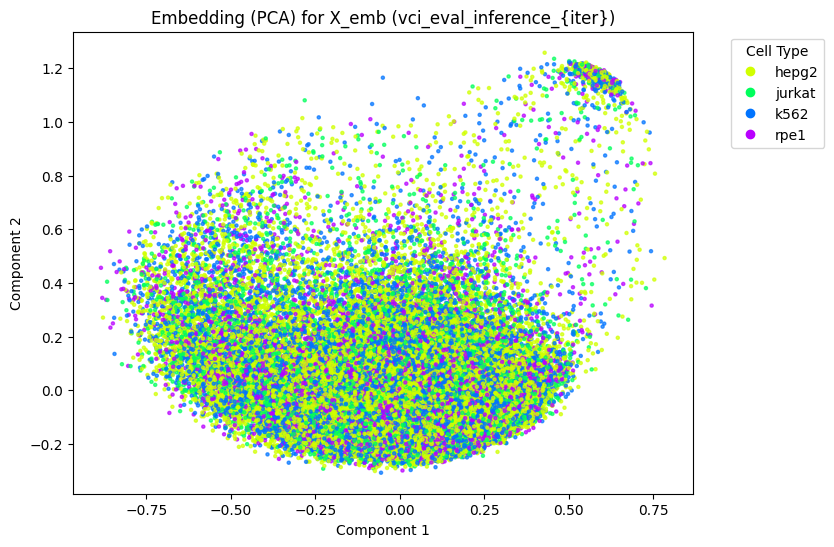

In [9]:
adata = sc.read_h5ad(output_emb_file)

# Choose embedding method: set use_pca = True for PCA, False for UMAP
use_pca = True  # Change to False to use UMAP
if use_pca:
    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2).fit_transform(adata.obsm[emb_key])
else:
    import umap
    embedding = umap.UMAP(n_components=2).fit_transform(adata.obsm[emb_key])

# Get the cell type information as a categorical series
cell_types = adata.obs['cell_type'].astype('category')

# Create a color palette based on the number of unique cell types
palette = sns.color_palette("hsv", len(cell_types.cat.categories))
color_dict = dict(zip(cell_types.cat.categories, palette))

# Instead of using .map (which may fail with a MultiIndex), use a list comprehension
colors = [color_dict[ct] for ct in cell_types]

# Plot the embedding
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=5, alpha=0.7)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Embedding ({}) for {} ({})".format("PCA" if use_pca else "UMAP", emb_key, job_name))

# Create legend handles for each cell type
handles = [
    mlines.Line2D([], [], color=color_dict[ct], marker='o', linestyle='None', markersize=6, label=ct)
    for ct in cell_types.cat.categories
]
plt.legend(handles=handles, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()